In [25]:
# install packages
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime
import emojis
import emoji
import regex
import re
import collections
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from wordcloud import WordCloud, STOPWORDS 
import string

pio.renderers.default = "svg"

In [26]:
messages = pd.read_csv('one_moore.csv')
messages.columns = map(str.lower, messages.columns)
messages.columns = messages.columns.str.replace(' ', '_')
messages.head()

,chat_session,message_date,delivered_date,read_date,service,type,sender_id,sender_name,status,subject,text,attachment,attachment_type
0,One Moore Football,2021-08-30 07:23:36,NaN,2021-08-30 07:26:04,SMS,Incoming,1.919949e+10,Ross Goldberg,Read,NaN,HAPPY MONDAY! The draft is Thursday night at 8...,NaN,NaN
1,One Moore Football,2021-08-30 07:24:13,NaN,2021-08-30 07:26:04,SMS,Incoming,1.518422e+10,Joe Mooney,Read,NaN,Pew pew pew,NaN,NaN
2,One Moore Football,2021-08-30 07:24:14,NaN,2021-08-30 07:26:04,SMS,Incoming,1.314579e+10,David Butler,Read,NaN,"Yusssss, app for for young people anyway",NaN,NaN
3,One Moore Football,2021-08-30 07:24:53,NaN,2021-08-30 07:26:04,SMS,Incoming,1.917829e+10,Melissa Ross,Read,NaN,Hahaha works for me 😝,NaN,NaN
4,One Moore Football,2021-08-30 07:25:08,NaN,2021-08-30 07:26:04,SMS,Incoming,1.603716e+10,Brendan Duggan,Read,NaN,Loved “HAPPY MONDAY! The draft is Thursday nig...,NaN,NaN


In [27]:
# my messages don't have sender names
messages.sender_name = messages.sender_name.fillna('Sara Riker')

#Images show as null in text
messages['message'] = np.where(messages["text"].isnull(), messages["attachment_type"], messages["text"] )

#tapbacks
tapbacks = ['Liked', 'Loved', 'Laughed', 'Emphasized', 'Disliked']
messages['tapback'] = np.where(messages['message'].str.split().str[0].isin(tapbacks), messages['message'].str.split().str[0], "")
messages['message'] = np.where(messages['message'].str.split().str[0].isin(tapbacks), messages['message'].str.split().str[0], messages['message'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages['date'] = pd.to_datetime(messages['message_date']).dt.date
messages['time'] = pd.to_datetime(messages['message_date']).dt.time

In [28]:
# Emojis
#messages['emoji'] = messages_final['message'].apply(lambda x: emojis.get(x))

def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

messages["emoji"] = messages["message"].apply(split_count)

#URLs
URLPATTERN = r'(https?://\S+)'
messages['links'] = messages.message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

#only columns I care about 
messages_final = messages[['date', 'time', 'sender_name', 'message', 'tapback', 'emoji', 'links']]

#counts
messages_final['Letter_Count'] = messages_final['message'].apply(lambda s : len(s))
messages_final['Word_Count'] = messages_final['message'].apply(lambda s : len(s.split(' ')))

ipykernel_launcher:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

ipykernel_launcher:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
messages_final.head()

,date,time,sender_name,message,tapback,emoji,links,Letter_Count,Word_Count
0,2021-08-30,07:23:36,Ross Goldberg,HAPPY MONDAY! The draft is Thursday night at 8...,,[],0,197,38
1,2021-08-30,07:24:13,Joe Mooney,Pew pew pew,,[],0,11,3
2,2021-08-30,07:24:14,David Butler,"Yusssss, app for for young people anyway",,[],0,40,7
3,2021-08-30,07:24:53,Melissa Ross,Hahaha works for me 😝,,[😝],0,21,5
4,2021-08-30,07:25:08,Brendan Duggan,Loved,Loved,[],0,5,1


# Summary Stats

In [30]:
total_messages = messages_final.shape[0]
emojis = sum(messages_final['emoji'].str.len())
links = np.sum(messages_final.links)

print("We sent", f"{total_messages:,d}", "total messages. There were", f"{emojis:,d}", "emojis and", links, "links sent.")

We sent 830 total messages. There were 26 emojis and 8 links sent.


In [31]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_final.sender_name.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_final[messages_final["sender_name"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]}:')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages:', f"{req_df.shape[0]:,d}")
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = round((np.sum(req_df['Word_Count']))/req_df.shape[0], 2)
  print('Words per message:', words_per_message)
  #media conists of media messages
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent:', emojis)
  #links consist of total links
  links = sum(req_df["links"])   
  print('Links Sent:', links)   
  print()

Stats of Ross Goldberg:
Messages: 137
Words per message: 7.41
Emojis Sent: 2
Links Sent: 5

Stats of Joe Mooney:
Messages: 127
Words per message: 5.98
Emojis Sent: 4
Links Sent: 0

Stats of David Butler:
Messages: 111
Words per message: 6.41
Emojis Sent: 2
Links Sent: 2

Stats of Melissa Ross:
Messages: 23
Words per message: 7.96
Emojis Sent: 6
Links Sent: 0

Stats of Brendan Duggan:
Messages: 130
Words per message: 3.75
Emojis Sent: 2
Links Sent: 1

Stats of Claire Soloman:
Messages: 58
Words per message: 4.9
Emojis Sent: 0
Links Sent: 0

Stats of Micheal Cass-Antony:
Messages: 25
Words per message: 6.96
Emojis Sent: 0
Links Sent: 0

Stats of Sara Riker:
Messages: 76
Words per message: 6.37
Emojis Sent: 7
Links Sent: 0

Stats of Jasper Guarnaccia:
Messages: 105
Words per message: 4.1
Emojis Sent: 1
Links Sent: 0

Stats of Max Nisen:
Messages: 9
Words per message: 8.44
Emojis Sent: 1
Links Sent: 0

Stats of Jess Thorn:
Messages: 20
Words per message: 8.0
Emojis Sent: 1
Links Sent: 0

S

# Tapbacks

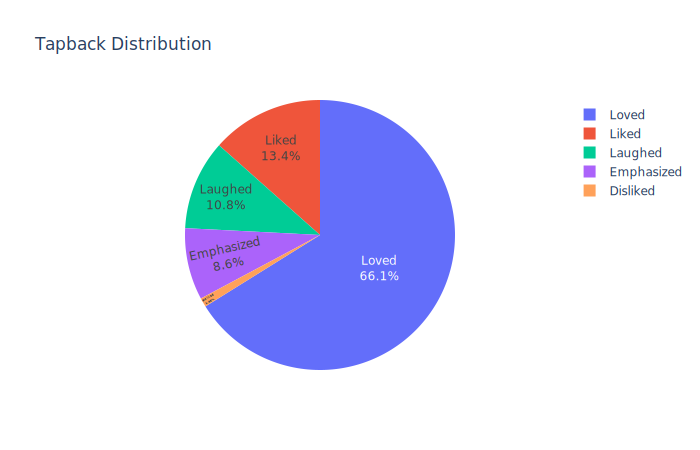

In [32]:
tb = messages_final[messages_final['tapback'] != ''].groupby('tapback')['message'].count().reset_index()
tb.columns = ['Tapback', 'Messages']
fig = px.pie(tb, values='Messages', names='Tapback',
             title='Tapback Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(renderer="svg")

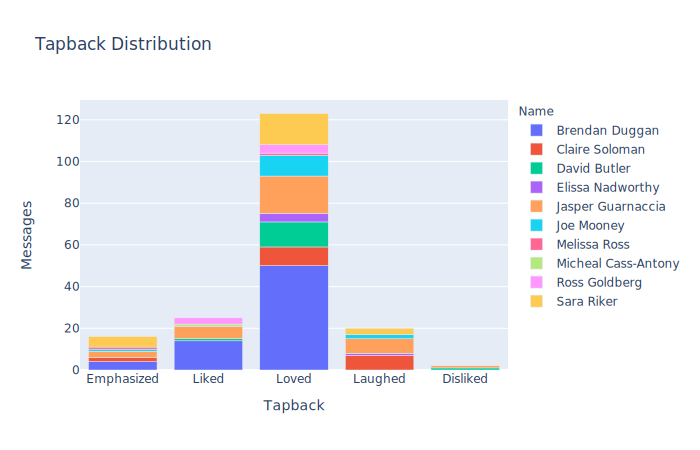

In [33]:
tb = messages_final[messages_final['tapback'] != ''].groupby(['sender_name', 'tapback'])['message'].count().reset_index()
tb.columns = ['Name','Tapback', 'Messages']

fig = px.bar(tb, y='Messages', x='Tapback', color = 'Name',
             title='Tapback Distribution')
fig.show(renderer="svg")

# Emojies

In [34]:
total_emojis_list = list([a for b in messages_final.emoji for a in b])
emoji_dict = dict(collections.Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😅,5
1,🤮,2
2,😬,2
3,😂,2
4,❤️,2
5,👀,2
6,😝,1
7,👍🏼,1
8,🤣,1
9,😷,1


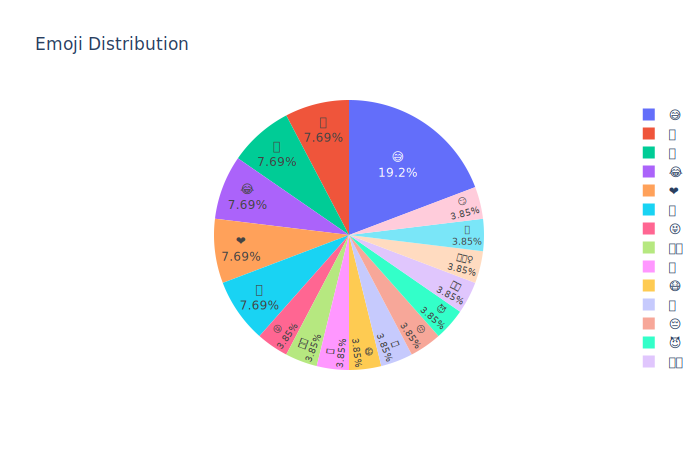

In [35]:
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(renderer="svg")

In [36]:
just_text = messages_final
just_text['message'] = just_text['message'].str.replace('[^A-Za-z\s]+', '')
just_text = just_text[messages_final['tapback'] == '']
just_text = just_text[just_text['message'] != 'Image']
just_text = just_text[just_text['message'] != 'Video']
just_text = just_text[just_text['links'] == 0]
text = "".join(review for review in just_text.message)
print ("There are {:,d} words in all the messages.".format(len(text)))

There are 21,208 words in all the messages.


ipykernel_launcher:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



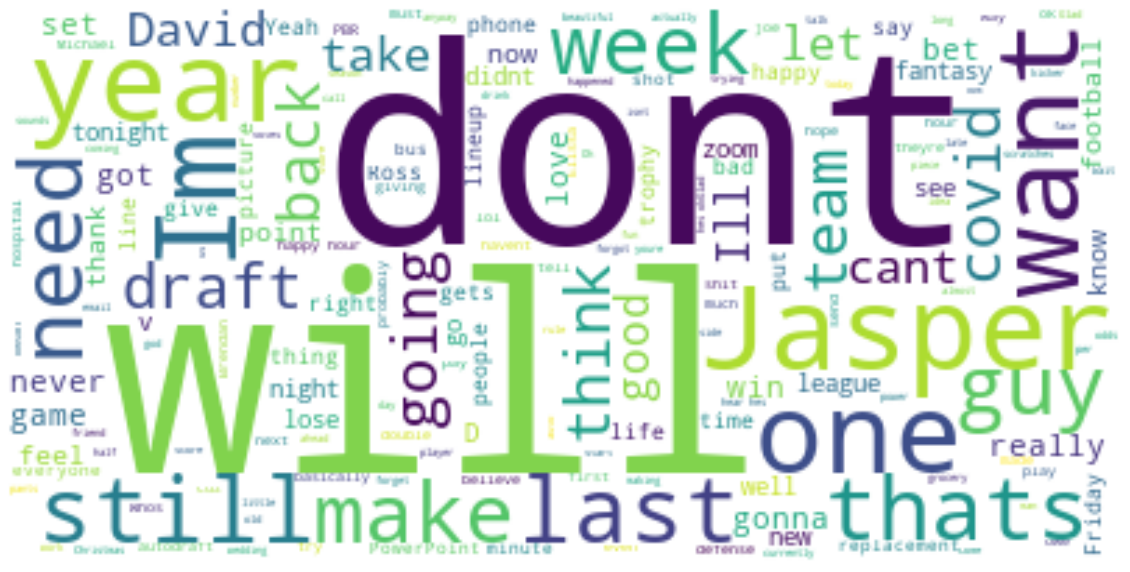

In [37]:
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:

plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Images and Videos

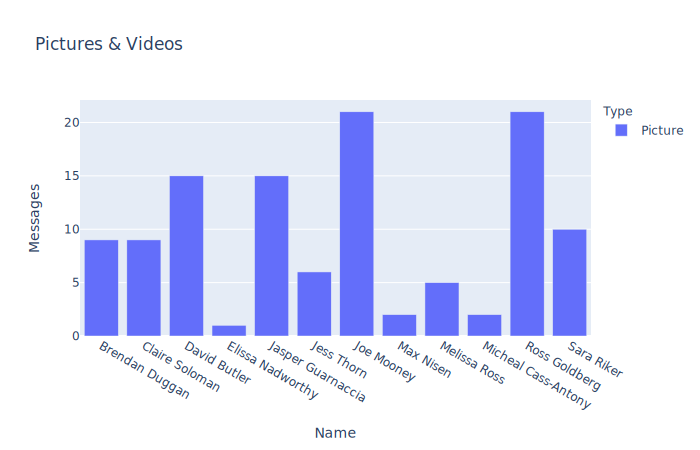

In [38]:
image = messages_final[messages_final['message'] == 'Image'].groupby(['sender_name'])['message'].count().reset_index()
image.columns = ['Name', 'Messages']
image['Type'] = "Picture"
videos = messages_final[messages_final['message'] == 'Video'].groupby(['sender_name'])['message'].count().reset_index()
videos.columns = ['Name', 'Messages']
videos['Type'] = "Video"
iv = image.append(videos)

fig = px.bar(iv, y='Messages', x='Name', color = 'Type',
             title='Pictures & Videos')
fig.show(renderer="svg")

# Date and Time

ipykernel_launcher:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



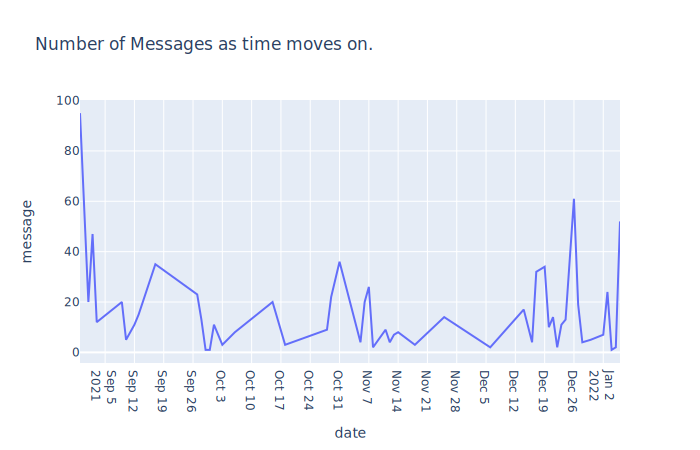

In [39]:
messages_final['date'] = pd.to_datetime(messages_final['date'])
date_df = messages_final[['date', 'message']].groupby("date").count()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="date", y="message", title='Number of Messages as time moves on.')
fig.update_xaxes(nticks=20)
fig.show(renderer='svg')

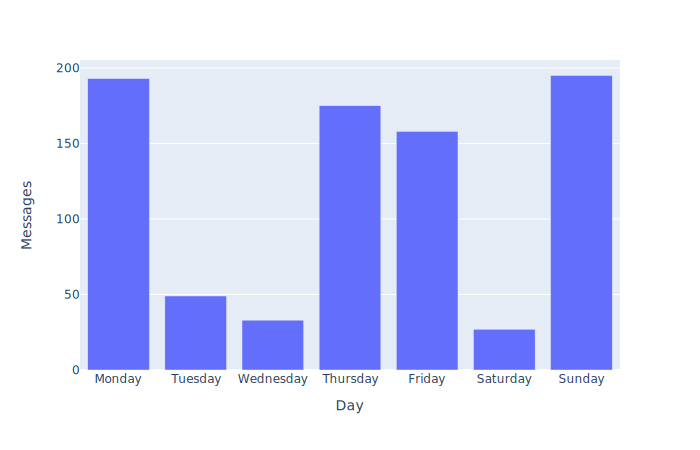

In [40]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
def dayofweek(i):
  d = days
  return d[i];
day_df=pd.DataFrame(messages_final["message"])
day_df['Day'] = messages_final['date'].dt.weekday
day_df['Day'] = day_df["Day"].apply(dayofweek)
day_df["Messages"] = 1
day = day_df.groupby("Day").sum()
day.reset_index(inplace=True)

day = day.set_index('Day').reindex(days).reset_index()
fig = px.bar(day, y='Messages', x='Day')
fig.show(renderer='svg')

Text(0, 0.5, 'time')

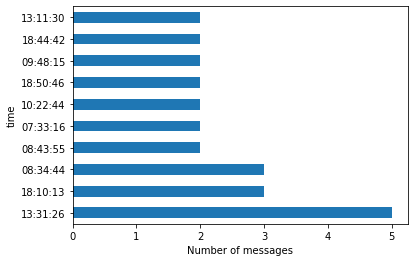

In [41]:
messages_final['time'].value_counts().head(10).plot.barh() 
plt.xlabel('Number of messages')
plt.ylabel('time')

# Sentiment Analysis

In [42]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /Users/SaraRiker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/SaraRiker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/SaraRiker/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/SaraRiker/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [43]:
sid = SentimentIntensityAnalyzer()
print(messages_final.message[100])
scores = sid.polarity_scores(messages_final.message[100])
for key in sorted(scores):
        print('{0}: {1}, '.format(key, scores[key]), end='')

My team happy hour got rescheduled so now I will autodraft from my kayak
compound: 0.5719, neg: 0.0, neu: 0.764, pos: 0.236, 

In [44]:
# below is the sentiment analysis code rewritten for sentence-level analysis
# note the new module -- word_tokenize!
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

# Next, we initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

# We will also initialize our 'english.pickle' function and give it a short name

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# The tokenize method breaks up the paragraph into a list of strings. In this example, note that the tokenizer is confused by the absence of spaces after periods and actually fails to break up sentences in two instances. How might you fix that?
text = "".join(review for review in messages.message)

sentences = tokenizer.tokenize(text)

# We add the additional step of iterating through the list of sentences and calculating and printing polarity scores for each one.

output = pd.DataFrame()

for sentence in sentences:
        scores = sid.polarity_scores(sentence)
        output = output.append(scores, ignore_index=True)

print(output.head())

   compound    neg    neu    pos
0    0.6114  0.000  0.200  0.800
1    0.0000  0.000  1.000  0.000
2   -0.8316  0.358  0.642  0.000
3    0.3612  0.000  0.737  0.263
4    0.7773  0.000  0.787  0.213


In [45]:
print("Compounded sentiment ranges from -1 to 1 and measures the overall sentiment of the text message. The average sentiment is {}, which means overall the messages are more positive than negative.".format(round(output.compound.mean(), 4)))


Compounded sentiment ranges from -1 to 1 and measures the overall sentiment of the text message. The average sentiment is 0.1606, which means overall the messages are more positive than negative.


In [46]:
output.describe()

,compound,neg,neu,pos
count,160.000000,160.000000,160.000000,160.000000
mean,0.160555,0.050294,0.838306,0.111419
std,0.422937,0.111217,0.183341,0.158779
min,-0.831600,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.743750,0.000000
50%,0.000000,0.000000,0.865000,0.051500
75%,0.491550,0.073000,1.000000,0.170500
max,0.967400,0.706000,1.000000,1.000000


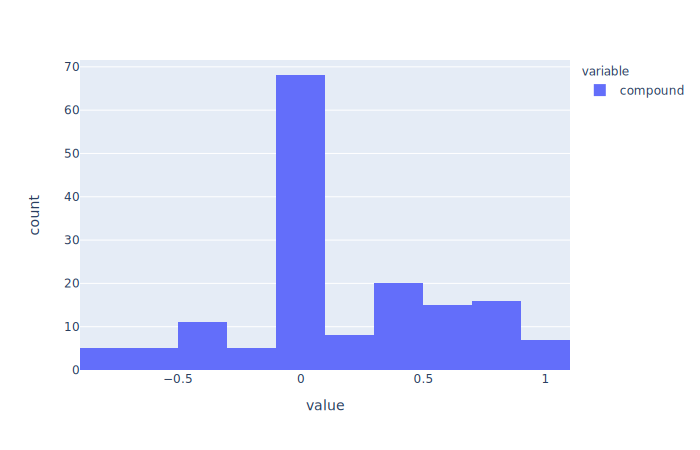

In [47]:
fig = px.histogram(output['compound'])
fig.show(renderer='svg')